<p style = "font-size : 42px; color : #393e46 ; font-family : 'Comic Sans MS'; text-align : center; background-color : #00adb5; border-radius: 5px 5px;"><strong>MultiDocs Q&A With RAG</strong></p>

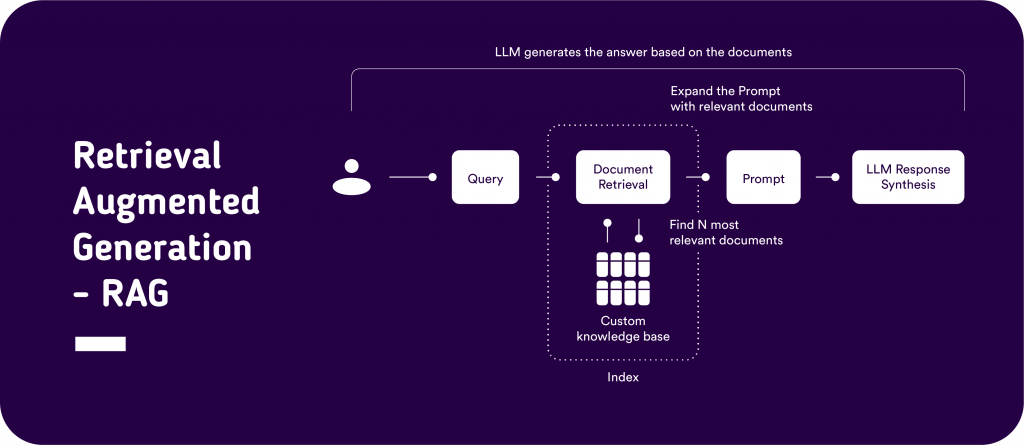

<p style = "font-size : 25px; color : #34656d ; font-family : 'Comic Sans MS';"><strong>Objective :</strong></p>
<p style = "font-size : 17px; color : #810000 ; font-family : 'Comic Sans MS'; ">The primary objective of this Kaggle notebook is to design, implement, and demonstrate a sophisticated question-answering system utilizing Retrieval-Augmented Generation (RAG) technology. This system will be capable of ingesting multiple documents as its knowledge base, understanding the context and nuances within these documents, and generating precise, informative answers to a wide range of user queries. By leveraging the RAG framework, the project aims to highlight the system's ability to perform real-time information retrieval from a diverse document set, fuse this information seamlessly, and produce answers that are not only accurate but also contextually enriched.</p>

<p style = "font-size : 25px; color : #34656d ; font-family : 'Comic Sans MS';"><strong>What is RAG ?</strong></p>

<ul>
    <li style = "font-size : 15px; color : #810000 ; font-family : 'Comic Sans MS'; ">RAG is a technique for augmenting LLM knowledge with additional data.</li>
    <li style = "font-size : 15px; color : #810000 ; font-family : 'Comic Sans MS'; ">LLMs can reason about wide-ranging topics, but their knowledge is limited to the public data up to a specific point in time that they were trained on. If you want to build AI applications that can reason about private data or data introduced after a model’s cutoff date, you need to augment the knowledge of the model with the specific information it needs. The process of bringing the appropriate information and inserting it into the model prompt is known as Retrieval Augmented Generation (RAG).</li>
</ul>

<p style = "font-size : 25px; color : #34656d ; font-family : 'Comic Sans MS';"><strong>RAG Architecture</strong></p>
<p style = "font-size : 15px; color : #810000; font-family : 'Comic Sans MS';"><strong>A typical RAG application has two main components: </strong></p>

<ol>
    <li style = "font-size : 15px; color : #810000 ; font-family : 'Comic Sans MS'; "><strong>Indexing:</strong> a pipeline for ingesting data from a source and indexing it. This usually happens offline.</li>
    <li style = "font-size : 15px; color : #810000 ; font-family : 'Comic Sans MS'; "><strong>Retrieval and generation:</strong> The actual RAG chain, which takes the user query at run time and retrieves the relevant data from the index, then passes that to the model.
</li>
</ol>

<p style = "font-size : 25px; color : #34656d ; font-family : 'Comic Sans MS';"><strong>Indexing:</strong></p>
<ol>
    <li style = "font-size : 15px; color : #810000 ; font-family : 'Comic Sans MS'; "><strong>Load:</strong> First we need to load our data. This is done with DocumentLoaders.</li>
    <li style = "font-size : 15px; color : #810000 ; font-family : 'Comic Sans MS'; "><strong>Split:</strong> Text splitters break large Documents into smaller chunks. This is useful both for indexing data and for passing it in to a model, since large chunks are harder to search over and won’t fit in a model’s finite context window.</li>
<li style = "font-size : 15px; color : #810000 ; font-family : 'Comic Sans MS'; "><strong>Store:</strong> We need somewhere to store and index our splits, so that they can later be searched over. This is often done using a VectorStore and Embeddings model.</li>
</ol>

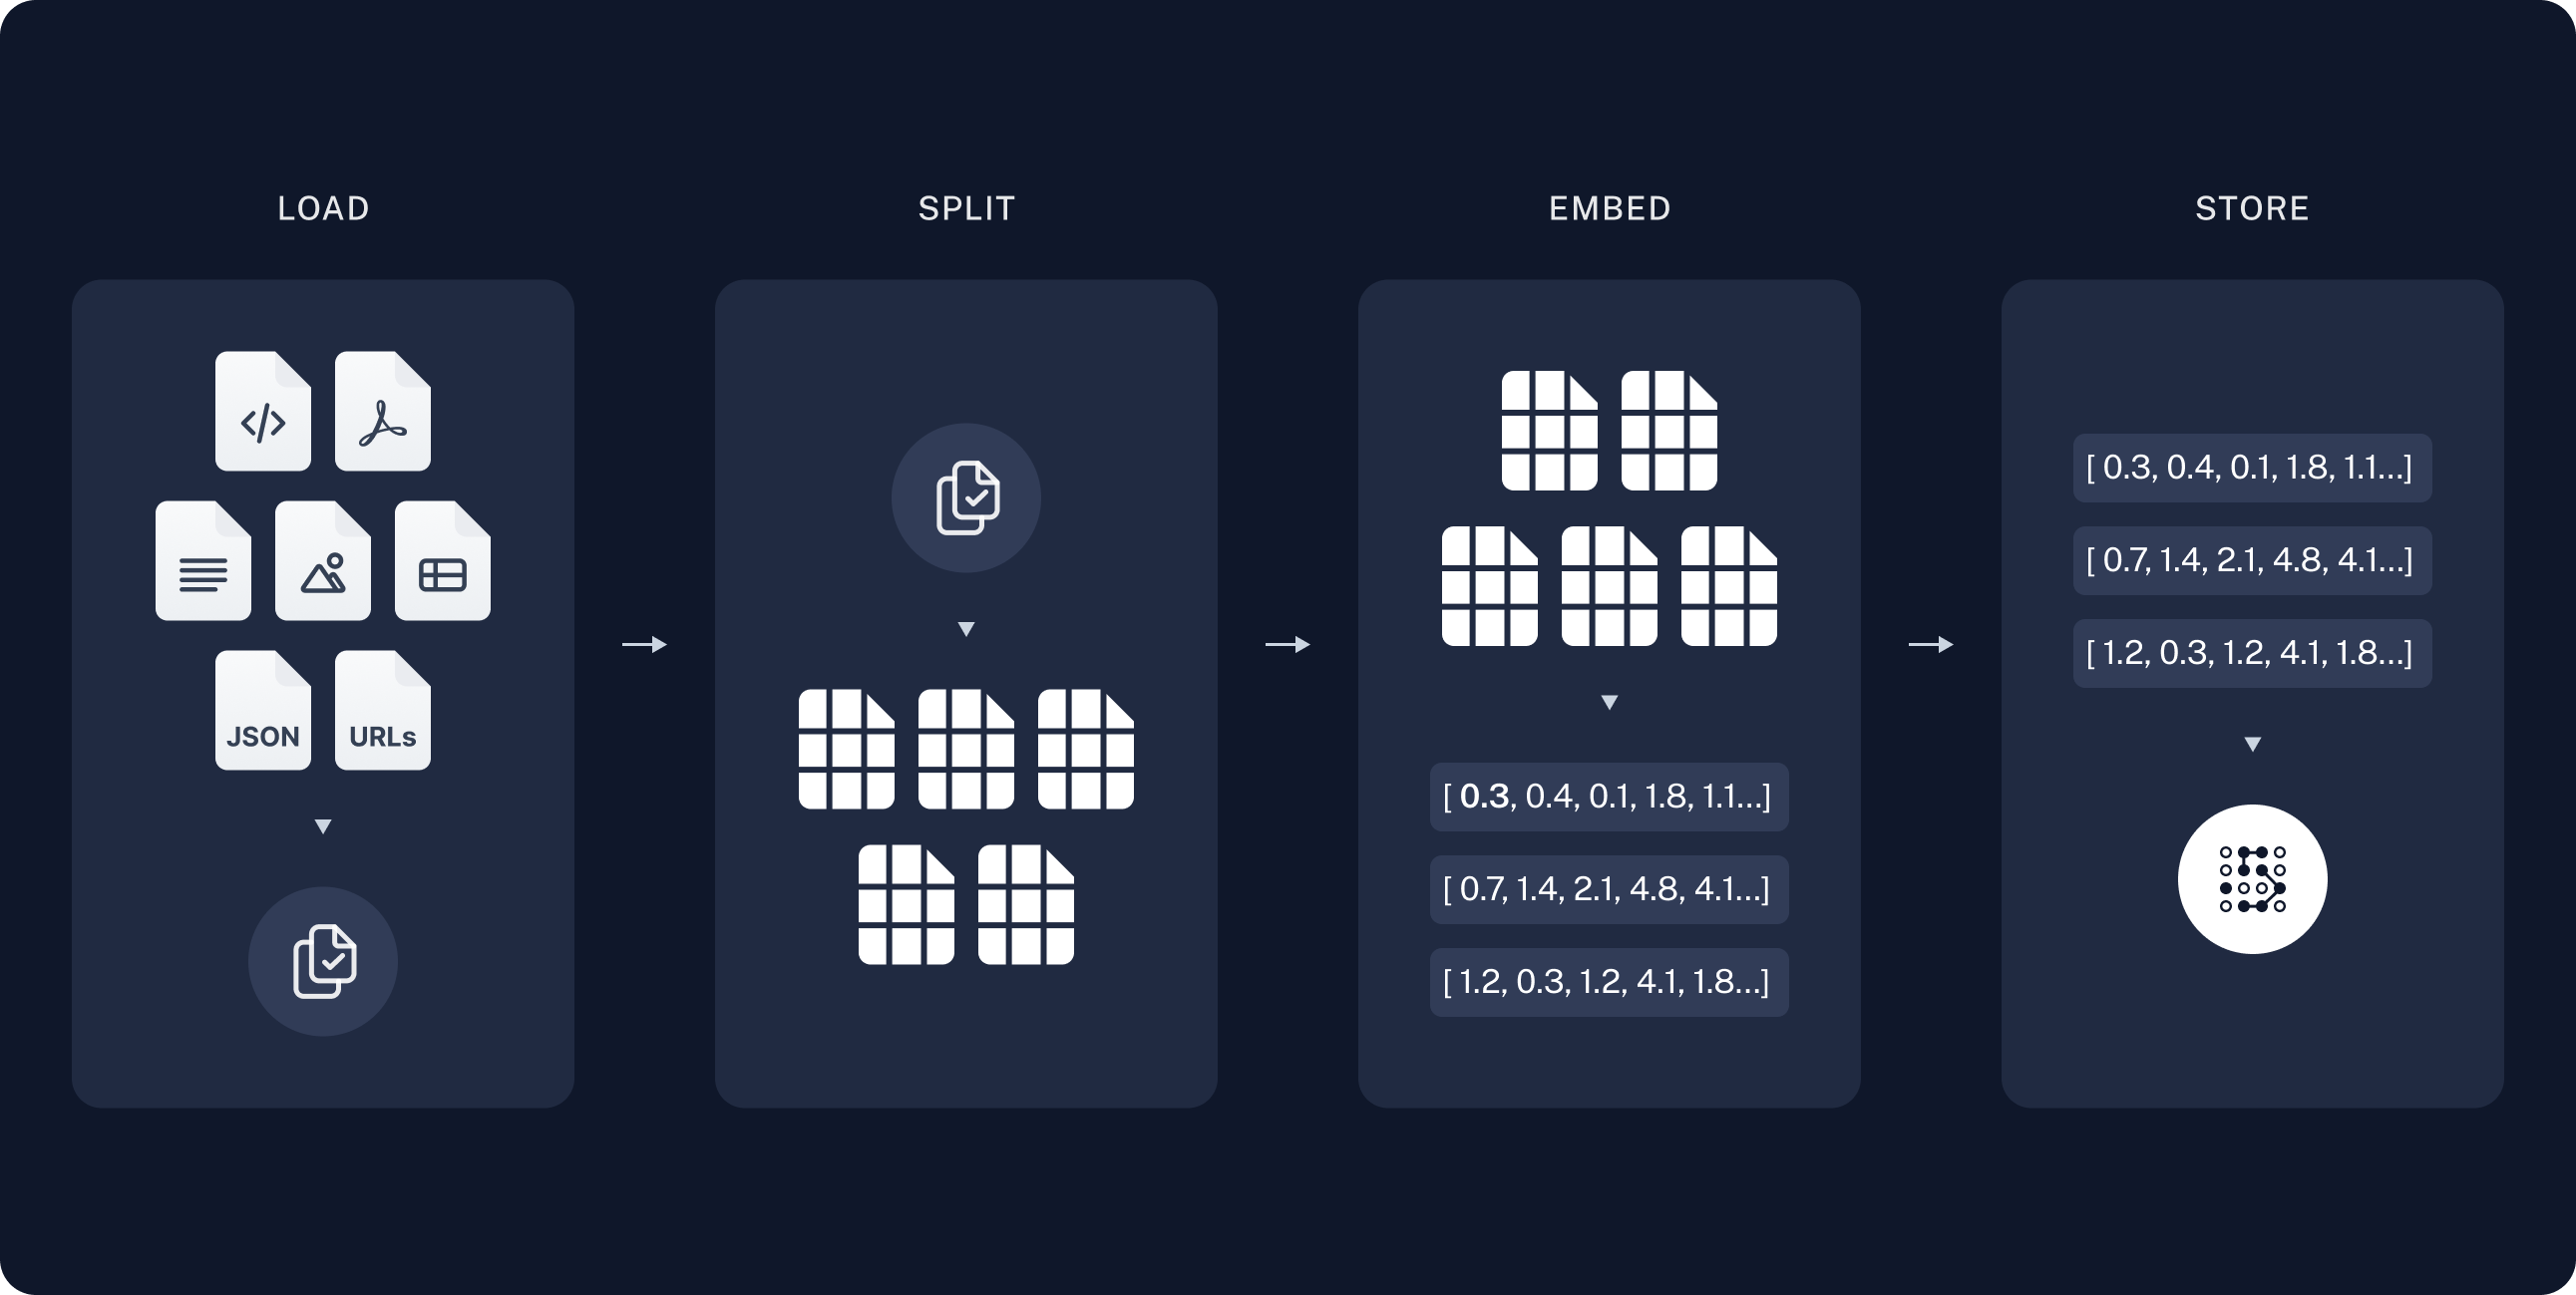

<p style = "font-size : 25px; color : #34656d ; font-family : 'Comic Sans MS';"><strong>Retrieval and Generation</strong></p>
<ol>
    <li style = "font-size : 15px; color : #810000 ; font-family : 'Comic Sans MS'; "><strong>Retrieve:</strong> Given a user input, relevant splits are retrieved from storage using a Retriever.</li>
    <li style = "font-size : 15px; color : #810000 ; font-family : 'Comic Sans MS'; "><strong>Generate:</strong> A ChatModel / LLM produces an answer using a prompt that includes the question and the retrieved data.</li>
</ol>

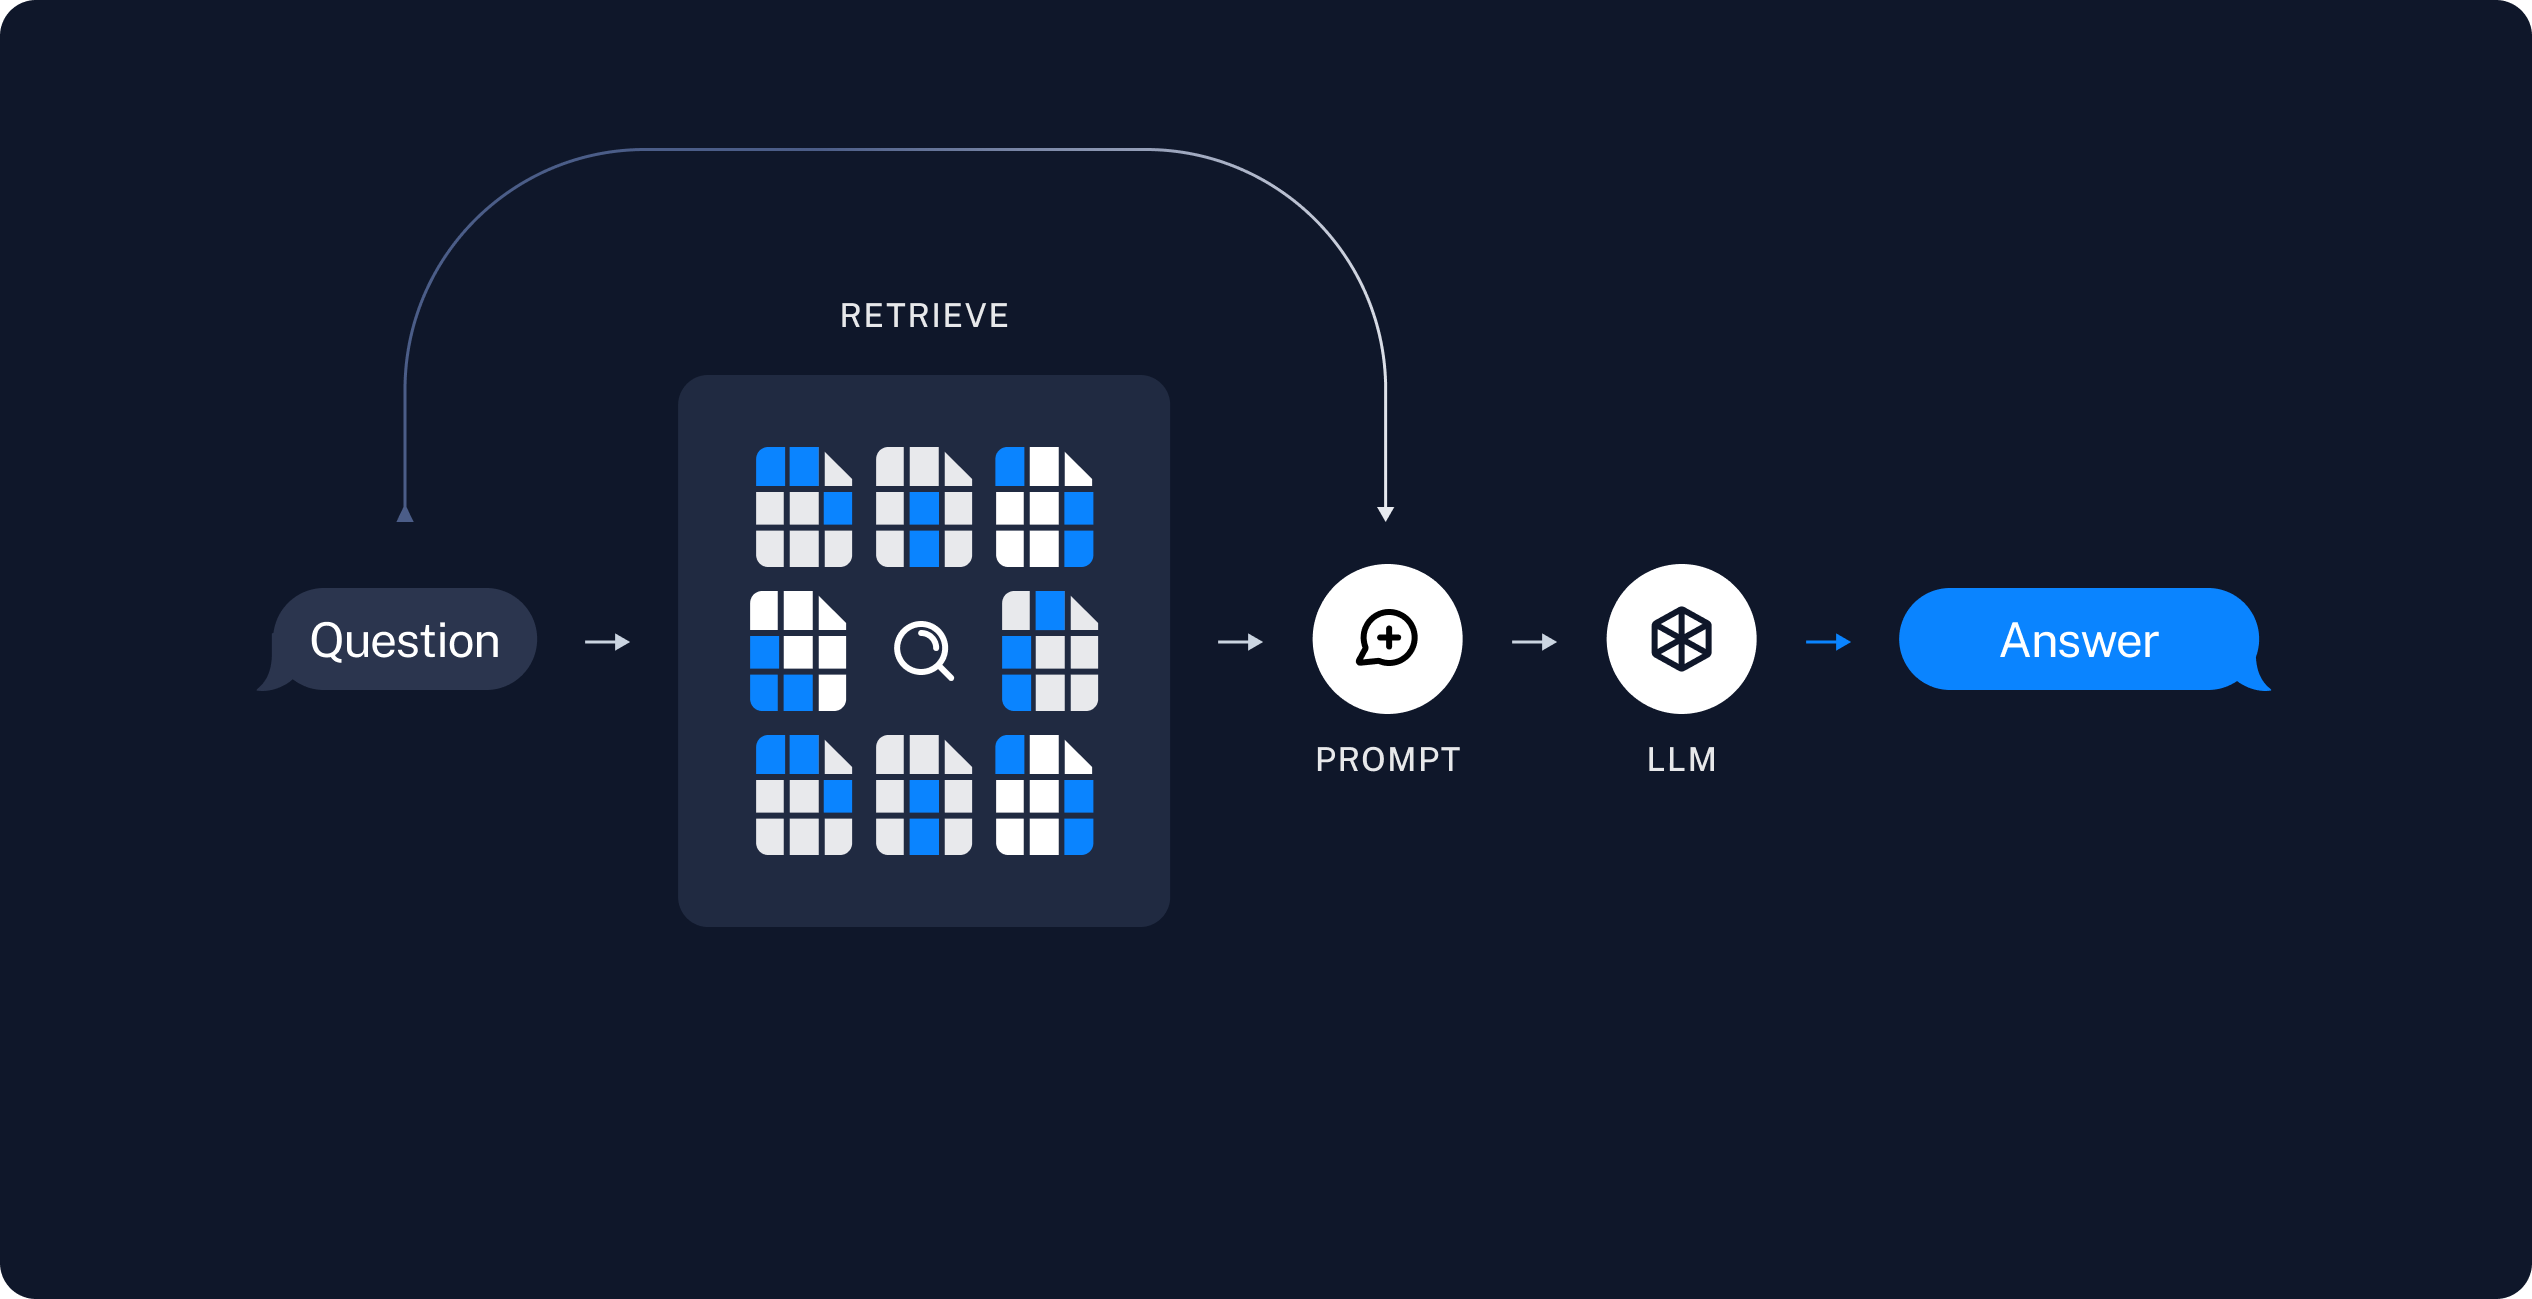

<a id = '0'></a>
<p style = "font-size : 35px; color : #34656d ; font-family : 'Comic Sans MS'; text-align : center; background-color : #f9b208; border-radius: 5px 5px;"><strong>Table of Contents</strong></p> 

* [Indexing](#1.0)
    * [Data Loading](#1.1)
    * [Data Extraction](#1.2)
    * [Chunking](#1.3)
    * [Embeddings Creation](#1.4)
    * [Indexing](#1.5)
    
    
* [Retrieval and Generation](#2.0)
    * [Retriever](#2.1)
    * [LLM Model](#2.2)


* [Results](#3.0)
* [Conclusion](#4.0)

In [ ]:
# Installing Required Libraries
%pip install -qq PyPDF2
%pip install -qq langchain
%pip install -qq langchain_community
%pip install -qq langchain_text_splitters
%pip install -qq sentence-transformers
%pip install -qq faiss-cpu
%pip install -qq cohere

In [2]:
# necessary Imports
import os
from PyPDF2 import PdfReader
from langchain_community.llms import Cohere  ### OpenAI
from langchain_community.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_core.runnables import RunnablePassthrough   ### for skipping variable inialisation
from langchain_core.output_parsers import StrOutputParser   ### for output
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.prompts  import PromptTemplate


<a id = '1.1'></a>
<p style = "font-size : 20px; color : #34656d ; font-family : 'Comic Sans MS'; "><strong>Data Loading</strong></p> 
<p style = "font-size : 15px; color : #810000 ; font-family : 'Comic Sans MS' ">For This Notebook, I have chosen my favourite subject, Statistics and the biography of Indian Olympian Abhinav Bhindra.</p>
<ul>

In [ ]:
class configuration:
    os.environ['HuggingFaceHub_API_Token']= <>
    os.environ['GOOGLE_API_KEY']= <>
    os.environ['cohere_api_key'] = <>

In [4]:
### Defining the helper function to load the data;

def data_load(path):
    all_text=''
    for i in path:
        pdf_file=open(i,'rb')
        # extracting pdf data
        pdf_text = ""
        pdf_reader = PdfReader(pdf_file)
        for page in pdf_reader.pages:
            pdf_text += page.extract_text()

        all_text = pdf_text + '\n'
        
    return all_text
    

In [5]:
## Defining the helper function in chunking of the data, helping in storing into the vector database;

def chunking(all_text):
    
    ## defining the text splitter object
    text_splitter = RecursiveCharacterTextSplitter(     ## from langchain_text_splitters import RecursiveCharacterTextSplitter
                chunk_size = 1000, 
                chunk_overlap = 200, # This is helpful to handle the data loss while chunking.
                length_function = len,
                separators=['\n', '\n\n', ' ', ''])   ### these are the default separators
    
    chunks = text_splitter.split_text(text = all_text)
    
    return chunks


                                           

In [ ]:
## Collecting the file path;

path1='PracticalStatisticsforDataScientists50EssentialConceptsUsingRandPythonbyPeterBruceAndrewBrucePeterGedeck.pdf'
path2='A Shot at History- Abhinav Bindra.pdf'

path=[path1,path2]

<a id = '1.2'></a>
<p style = "font-size : 20px; color : #34656d ; font-family : 'Comic Sans MS'; "><strong>Data Extraction</strong></p> 
<ul>
    <li style = "font-size : 15px; color : #810000 ; font-family : 'Comic Sans MS'; "><strong>PDF :-</strong> Pdf data is extracted using PyPDF2 and all text is stored in a string.</li>

In [7]:
## Loading the data as a list of text;
all_text=data_load(path)

In [8]:
## Breaking down the data into chunks;
chunks=chunking(all_text)

<a id = '1.4'></a>
<p style = "font-size : 20px; color : #34656d ; font-family : 'Comic Sans MS'; "><strong>Embeddings Creation</strong></p> 

<p style = "font-size : 15px; color : #810000 ; font-family : 'Comic Sans MS' ">Embeddings creation is a crucial preprocessing step in the development of document-based Question and Answering (Q&A) systems. This process involves converting textual data from documents and questions into dense, high-dimensional vectors known as embeddings. These embeddings are designed to capture the semantic meaning of words, sentences, or even entire documents, enabling the Q&A system to understand and process natural language more effectively.</p>

In [9]:
# Initializing embeddings model

embeddings = HuggingFaceEmbeddings(model_name='sentence-transformers/all-MiniLM-L6-v2')

/tmp/ipykernel_105/1656794730.py:3: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name='sentence-transformers/all-MiniLM-L6-v2')
2025-02-15 17:54:33.683538: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-15 17:54:33.683690: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-15 17:54:33.834936: E external/local_xla/xla/stream_executor/c

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

<a id = '1.5'></a>
<p style = "font-size : 20px; color : #34656d ; font-family : 'Comic Sans MS'; "><strong>Indexing</strong></p> 
<p style = "font-size : 15px; color : #810000 ; font-family : 'Comic Sans MS' ">Indexing data using Facebook AI Similarity Search (FAISS) is a pivotal step in developing efficient and scalable document-based Question and Answering (Q&A) systems. FAISS is a library that facilitates the efficient search for similarities in large datasets, especially useful for tasks involving high-dimensional vectors like text embeddings. When applied to document-based Q&A, FAISS indexes the embeddings of document chunks (e.g., paragraphs, sentences) to optimize the retrieval process.</p>

In [10]:
# Indexing the data using FAISS database
vectorstore = FAISS.from_texts(chunks, embedding = embeddings)  ## from langchain_community.vectorstores import FAISS

<a id = '2.1'></a>
<p style = "font-size : 20px; color : #34656d ; font-family : 'Comic Sans MS'; "><strong>Retriever</strong></p> 
<p style = "font-size : 15px; color : #810000 ; font-family : 'Comic Sans MS' ">In the development of document-based Question and Answering (Q&A) systems, creating a retriever is a crucial step that directly impacts the system's ability to find relevant information efficiently. The retriever utilizes the pre-indexed embeddings of document chunks, searching through them to find the most relevant pieces of content in response to a user query. This process involves setting up a retrieval mechanism that leverages similarity search to identify the best matches for the query embeddings within the indexed data.</p>

In [11]:
# creating retriever
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 6})

## Retrives the most relevant information based on the given query;
retrieved_docs = retriever.invoke("What is an outlier?")

In [46]:
type(retrieved_docs)

list

In [47]:
prompt_template = """Answer the question as precise as possible using the provided context. If the answer is
                not contained in the context, say "answer not available in context" \n\n
                Context: \n {context}?\n
                Question: \n {question} \n
                Answer:"""

prompt = PromptTemplate.from_template(template=prompt_template)

## from langchain_core.prompts  import PromptTemplate

In [48]:
# function to create a single string of relevant documents given by Faiss.
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [49]:
# RAG Chain

def generate_answer(question):
    
    ### Defining the model;
    cohere_llm = Cohere(model="command", temperature=0.1, cohere_api_key = os.getenv('cohere_api_key'))
    
    ## Creating the chain;
    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt
        | cohere_llm
        | StrOutputParser()
    )
    
    return rag_chain.invoke(question)

<a id = '3.0'></a>
<p style = "font-size : 20px; color : #34656d ; font-family : 'Comic Sans MS'; "><strong>Results</strong></p> 

In [50]:
ans = generate_answer("What is an outlier in statistics?")
print(ans)

 answer not available in context


In [51]:
ans = generate_answer("How to build a linear regression model?")
print(ans)

 answer not available in context


In [40]:
ans = generate_answer("What is PCA?")
print(ans)

 answer not available in context


In [41]:
ans = generate_answer("Why do we need scaling?")
print(ans)

 Answer not available in context


In [42]:
ans = generate_answer("Which algorithms require Scaling?")
print(ans)

 answer not available in context


In [43]:
retriever.search_kwargs["k"]


6